# DeepONet Tutorial

**Note:** this tutorial is fork from John Su under MIT license. Some contents have been modified.

---

MIT License

Copyright (c) 2024 John Su

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

---

## Introduction

This notebook gives a brief introduction to DeepOnets by Lu et al in their paper found [here](https://arxiv.org/abs/1910.03193). Here we aim to create an Operator network that can solve the following similar 1D ODE problem given in the paper:
$$
\frac{d}{dx}F(x) = g(x) \\
F(0) = 0\\
for \  x \in [0,2]
$$

Where $g(x)$ is given. This is essentially integration of a 1D function with the initial condition $F(0) = 0$. In practice, the operator mapping can be fairly arbitary e.g. initial states, boundary conditions, partial data, etc.

We look at 2 different approaches: Data Driven and physics informed. Data Driven has faster convergence and is more straight forward but requires data which may not neccesarily be available for more complicated Operators. Physics informed does not need any data (other than $F(0) = 0$ and the equations governing the Operator) but is slower to train

Like regular deep learning tasks such as image classification or NLP, sampling too far out of training distribution (i.e. a $g(x)$ too wildly different from the given dataset) will cause the operator network to fail to produce the correct results.

<img src='assets/img/Different a.gif'>

## Network Architecture

![DeepONet](./assets/img/deeponet.png)
This figure is downloaded from [Nature Machine Learning](https://www.nature.com/articles/s42256-021-00302-5)

The network $G(u)(y)$ takes in two inputs: $y$ and $u$.

> Here 'u' represents the $g(x)$ in our problem. Because of the structure of networks, we have to discretize the function $g$ at a fixed number of grid points. We'll use 100 uniformly spread points across the range 0 to 2.  
> Note that the location of each sensor $u(x_i)$ is implicitly given (i.e. we don't tell the network this info but it is baked via our training samples) and remains fixed for all $g$) 

> Here 'y' represents the points we want to query. Because $g(x)$ takes the range (0,2), any y points we specify will also need to take the range (0,2).

The DeepONet uses a the stacked net from Lu et al. Essentially, there are two seperate networks called branch and trunk network handling the input function and sampling point, respectively. They are merged at some latent representation through element wise multiplication and then passed through a final linear layer.



For both the trunk and branch net, we'll just use the standard MLP networks with tanh activations.

The number of sensors for $u(x)$ can be different to the number of points we sample. In other words, the input shapes to the trunk and branch net can be different. This means we need 2 'batch' dimensions to loop over - one to handle the trunk net and one for the branch net. Base on how `nn.Linear` works we define the inputs to the Onet as:

- branch net $u(x)$ has shape [B,1,M]
- trunk net input has shape [B,N,I]
- Output of Onet shape [B,N,O]

Where:
- B is the batch dimension for the branch net
- N is the 'batch' dimension for the trunk net
- M is the number of sensors that discretize u(x)/input dimension of the branch net
- I is the input dimension of the trunk net
- O is the output dimension size of the Onet

For this example:
$$
B = 10,000\\
N = 100\\
M = 100\\
I = 1\\
O = 1\\
$$

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Set random seed, so that the result can be reproduced
def set_random_seed(seed: int) -> None:
	# random.seed(seed)
	# os.environ['PYTHONHASHSEED'] = str(seed)
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed_all(seed)
	torch.backends.cudnn.benchmark = False
	torch.backends.cudnn.deterministic = True

seed = 12
set_random_seed(seed)

In [5]:
class MLP(nn.Module):
    def __init__(self, in_features: int, out_features: int, hidden_features: int, num_hidden_layers: int) -> None:
        super().__init__()

        self.linear_in = nn.Linear(in_features, hidden_features)
        self.linear_out = nn.Linear(hidden_features, out_features)
        self.linear_hidden = nn.ModuleList([nn.Linear(hidden_features, hidden_features) for _ in range(num_hidden_layers)])

        self.activation = torch.tanh
        
    def forward(self, x):
        x = self.linear_in(x)
        x = self.activation(x)

        for layer in self.linear_hidden:
            x = self.activation(layer(x))
    
        return self.linear_out(x)


class DeepONet(nn.Module):
    def __init__(self, latent_features, out_features, branch, trunk) -> None:
        super().__init__()
        self.branch = branch
        self.trunk = trunk
        self.fc = nn.Linear(latent_features, out_features, bias = False)

    def forward(self, y, u):
        return self.fc(self.trunk(y) * self.branch(u))

In [6]:
B = 2 # batch dimension of branch net
N = 40 # batch dimension of trunk net
M = 100 # input dimension of branch net
I = 1 # input dimension of trunk net
L = 75 # output dimension of branch/truck net, number of latent(input) features of ONet
O = 1 # output dimension of Onet

# other parameters (except the above 6 params), like 75 and 4 can be selected as other number
Onet = DeepONet(latent_features = L, out_features = O, branch = MLP(M, L, 75, 4), trunk = MLP(I, L, 75, 4))

u = torch.rand((B, 1, M))
y = torch.rand((B, N, I))

tt = Onet.branch(u) # torch.Size([2, 1, 75])
xx = Onet.trunk(y)  # torch.Size([2, 40, 75])

Onet(y, u).shape # torch.Size([2, 40, 1])

torch.Size([2, 40, 1])

## Generating Data

We'll generate our derivatives $u(x)$ using Chebyshev polynomials. There's many different ways of generating random smooth functions but well use this way.

We use a mix of numpy and scipy integration to get the derivative and the integral function at each point.

We then discretize both functions. For the derivative $u(x)$ we discretize using $M = 100$ uniformly spaced points. for $G(u)(y)$ we randomly sample $N = 100$ points in the domain.

The tuple of data of the shape $(y, u, G(u)(y))$ where:
- y is the sampling points of shape $[10000, 100, 1]$
- u is the discretized derivative function of shape $[10000, 1, 100]$
- $G(u)(y)$ is target output of the Onet os shape $[10000, 100, 1]$

> We mentioned above that:
> - branch net $u(x)$ has shape [B,1,M]
> - trunk net input has shape [B,N,I]
> - Output of Onet shape [B,N,O]
> Where:
> - B is the batch dimension for the branch net
> - N is the 'batch' dimension for the trunk net
> - M is the number of sensors that discretize u(x)/input dimension of the branch net
> - I is the input dimension of the trunk net
> - O is the output dimension size of the Onet
> 
> For this example:
> $$
> B = 10,000\\
> N = 100\\
> M = 100\\
> I = 1\\
> O = 1\\
> $$


In [7]:
from numpy.polynomial.chebyshev import Chebyshev, chebval, chebint, cheb2poly


def random_chebyshev(n, M, degree, return_coeff = False):
    '''
    This generates a random function output between the domain [-1,1]
    along a uniform grid of size n using chebyshev polynomials.
    '''
    coeff = (np.random.rand(degree+1) - 0.5) * 2 * np.abs(M)

    x= np.linspace(-1, 1, n)
    y = chebval(x, coeff)

    if return_coeff:
        return x, y, coeff
    else:
        return x, y

Now let's test the `random_chebyshev` function, and calculate its integration using scipy.

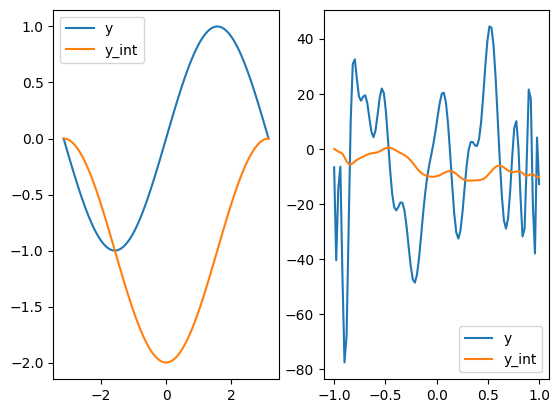

In [8]:
from scipy.integrate import cumulative_trapezoid


# test the integration function using sine function
plt.subplot(1, 2, 1)

x = np.linspace(-np.pi, np.pi, 100)
y = np.sin(x)
y_int = cumulative_trapezoid(y, x, initial = 0)

plt.plot(x, y, label = 'y')
plt.plot(x, y_int, label = 'y_int')
plt.legend()


# test the integration function using Chebyshev polynomial function
plt.subplot(1, 2, 2)

x, y, coeff = random_chebyshev(100, 10, 30, return_coeff = True)
y_int = cumulative_trapezoid(y, x, initial = 0)

plt.plot(x, y, label = 'y')
plt.plot(x, y_int, label = 'y_int')
plt.legend()

Next, we generate data tuples.

In [9]:
# Generate DataTuples:
def generate_data(n_samples, a, b, n_sensors, n_points, M, degree, y0 = 0, random_query = False, seed = 1234):
    '''
    Generate Data needed for training.

    Returns:
        A tuple of (y, u, Guy) that will be added to the Dataloader

    Params:
        - n_samples : number os samples. One sample contains 1 discreted u function, y vector and conrresponding G(u)(y) vector
        - a : lower boundary
        - b : upper boundary
        - n_sensors : number of observations of Chebyshev polynominal u. They are uniformly distributed in domain [-1, 1].
        - n_points : number of observations of G(u); or number of y
        - M : parameter of Chebyshev polynomials
        - degree : degree of Chebyshev polynomials
        - y0 : initial value for integration
        - random_query : whether to generate random y points or not. If True, y will be random in [-1, 1]
        - seed : seed for reproducibility
    '''

    if seed is not None:
        np.random.seed(1234)
    else:
        np.random.seed(seed)
    
    # Generate u(x)
    # Size of u: (100, 100), the former is n_samples, the latter is n_sensors
    u = [random_chebyshev(n_sensors, M, degree, return_coeff=False)[1] for _ in range(n_samples)]
    u = np.stack(u, axis = 0)

    # Generate y
    # Size of y: (100, 100), the former is n_samples, the latter is n_points
    if random_query:
        y = np.random.rand(n_samples, n_points) * (b - a) + a
    else:
        # y = np.array([np.linspace(a,b,n_points) for _ in range(n_samples)]
        y = np.tile(np.linspace(a, b, n_points), (n_samples, 1))

    # Generate G(u)(y)
    # Integrate cheb poly, we use interp in case we want random y points
    ip = np.linspace(a, b, n_sensors) # integration points
    Guy = [cumulative_trapezoid(u_sample, ip, initial = y0) for u_sample in u]
    Guy = [np.interp(yy, ip, G) for yy, G in zip(y, Guy)]

    # Guy data needs 2 batch dimensions: One for samples and the other for  
    u = torch.tensor(u, dtype = torch.float32) # torch.Size([100, 100])
    y = torch.tensor(y, dtype = torch.float32) # torch.Size([100, 100])
    Guy = torch.tensor(Guy, dtype = torch.float32) # torch.Size([100, 100])

    # To match network shape input and output, need to add a tensor dimension to y and Guy
    return y.unsqueeze(-1), u.unsqueeze(1), Guy.unsqueeze(-1)

Then, we test the `generate_data` function.

torch.Size([100, 100, 1]) torch.Size([100, 1, 100]) torch.Size([100, 100, 1])


C:\Users\43757\AppData\Local\Temp\ipykernel_32876\1701064999.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  Guy = torch.tensor(Guy, dtype = torch.float32) # torch.Size([100, 100])


Text(0.5, 1.0, '8th u/y/Guy sample')

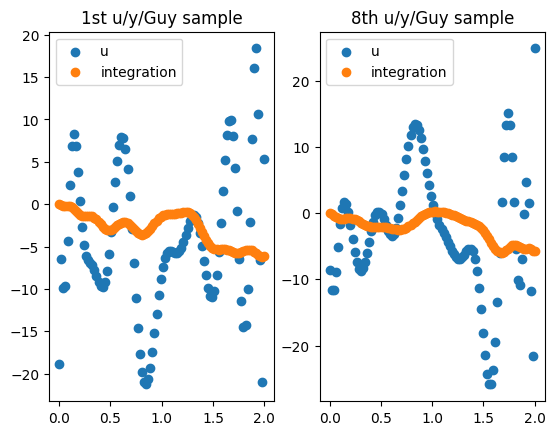

In [10]:
ys, us, Guys = generate_data(n_samples= 100, a = 0, b = 2, n_sensors = 100, n_points = 100, M = 5, degree = 20)
print(ys.shape, us.shape, Guys.shape)

ip = np.linspace(0, 2, 100) # boundray must correspond to the a & b in `generate_data` function

plt.subplot(121)
plt.scatter(ip, us[2].squeeze(), label='u')
plt.scatter(ys[0].squeeze(), Guys[0].squeeze(), label='integration')
plt.legend()
plt.title("1st u/y/Guy sample")

plt.subplot(122)
plt.scatter(ip, us[7].squeeze(), label='u')
plt.scatter(ys[7].squeeze(), Guys[7].squeeze(), label='integration')
plt.legend()
plt.title("8th u/y/Guy sample")

## Training DeepONet

We can then create a very straight forward training pipeline to train our data driven Onet. This is identical to other training pipelines such as image classification and we can simply use a dataloader

In [11]:
from torch.utils.data import DataLoader, Dataset

In [12]:
class Onet_dataset(Dataset):
    def __init__(self, y, u, Guy):
        self.y = y
        self.u = u
        self.Guy = Guy
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.y[idx], self.u[idx], self.Guy[idx]

In [13]:
# Generate training data
ys, us, Guys = generate_data(n_samples=10000, a=0, b=2, n_sensors=100, n_points=90, M=5, degree=20)
Onet_data = Onet_dataset(ys, us, Guys)
Onet_dataloader = DataLoader(Onet_data, batch_size = 1000, shuffle = True)

# Construct DeepONet model
Onet = DeepONet(75, 1, branch = MLP(100,75,75,4), trunk = MLP(1,75,75,4))

In [14]:
# Other training parameters
n_epoch = 10000
optimiser = Adam(Onet.parameters(), lr = 5e-4)
lr_sch = torch.optim.lr_scheduler.StepLR(optimiser, 1000, 0.95)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fun = nn.MSELoss()

# Generate a validation sample
x = torch.linspace(0, 2, 100)
a = 4
dy = torch.sin(a * x)

x_in = x.unsqueeze(0).unsqueeze(-1)
dy_in = dy.unsqueeze(0).unsqueeze(1)
out_true = -1/a * (torch.cos(a * x) - 1) # integration of sin(4x); the `-1` term is a result of initial condition `y0 = 0`

# Set training device
Onet = Onet.to(device)

x_in = x_in.to(device)
dy_in = dy_in.to(device)
out_true = out_true.to(device)

In [15]:
optimiser.zero_grad()

loss_list = []
acc_list = []
largest_loss = 1E10


for epoch in range(n_epoch):
    for (y, u, Guy) in Onet_dataloader:
        (y, u, Guy) = (y.to(device), u.to(device), Guy.to(device))
        out = Onet(y, u)

        loss = loss_fun(out, Guy)

        # Save the model with best loss
        if float(loss) < largest_loss:
            torch.save(Onet, f'assets/weights/DeepONet_Tutorial_best.pth')

        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        lr_sch.step()

    # Evaluating on validation dataset, and record loss and accuracy every 100 epochs (and the last epoch)
    if (epoch % 100) == 0 or (epoch == n_epoch - 1):
        with torch.no_grad():
            out = Onet(x_in, dy_in).squeeze()
            accuracy = (out - out_true).pow(2).mean()
        
        print(f'Epoch: {epoch} loss {float(loss):.5e} Acc {float(accuracy):.5e} lr {float(lr_sch.get_last_lr()[0]):.5e}')
        loss_list.append(float(loss))
        acc_list.append(float(accuracy))
    
        if epoch == n_epoch - 1:
            torch.save(Onet, f'assets/weights/DeepONet_Tutorial_last.pth')

Epoch: 0 loss 1.57672e+01 Acc 6.47673e-02 lr 5.00000e-04
Epoch: 100 loss 5.58895e-01 Acc 4.89119e-01 lr 4.75000e-04
Epoch: 200 loss 3.16823e-01 Acc 2.68027e-02 lr 4.51250e-04
Epoch: 300 loss 1.97243e-01 Acc 1.16265e-02 lr 4.28687e-04
Epoch: 400 loss 1.51005e-01 Acc 1.93452e-03 lr 4.07253e-04
Epoch: 500 loss 1.24836e-01 Acc 3.40725e-04 lr 3.86890e-04
Epoch: 600 loss 1.08756e-01 Acc 4.82543e-04 lr 3.67546e-04
Epoch: 700 loss 8.58816e-02 Acc 3.04189e-04 lr 3.49169e-04
Epoch: 800 loss 7.78153e-02 Acc 2.41341e-04 lr 3.31710e-04
Epoch: 900 loss 6.81927e-02 Acc 2.81053e-04 lr 3.15125e-04
Epoch: 1000 loss 4.58253e-02 Acc 1.90770e-04 lr 2.99368e-04
Epoch: 1100 loss 4.29406e-02 Acc 1.23856e-04 lr 2.84400e-04
Epoch: 1200 loss 3.75581e-02 Acc 6.07894e-04 lr 2.70180e-04
Epoch: 1300 loss 3.22815e-02 Acc 1.40904e-04 lr 2.56671e-04
Epoch: 1400 loss 3.01447e-02 Acc 1.89661e-04 lr 2.43837e-04
Epoch: 1500 loss 3.23498e-02 Acc 1.41990e-04 lr 2.31646e-04
Epoch: 1600 loss 2.31859e-02 Acc 3.88570e-04 lr 2.20

## Testing

Now, DeepONet is trained. And let's test its performance.

In [34]:
def test_onet(x: list[torch.Tensor], y: list[torch.Tensor], out_true: list[torch.Tensor], titles: list[str]):
    """
    Parameters:
        - x: list[torch.Tensor]
            e.g. [torch.linspace(0, 2, 100), torch.linspace(0, 2, 100), torch.linspace(0, 2, 200)]
        - y: list[torch.Tensor]
            e.g. [torch.sin(x1), torch.log(x2), x3 ** 2]
        - out_true: list[torch.Tensor]
            e.g. [-torch.cos(x1), x2 * (torch.log(x2) - 1), 1/3 * x3 ** 3]
        - titles: list[str]
            e.g. ["Indefinite Integral for sin(x)", "log(x)", "x ** 2"]
    """
    
    assert len(x) == len(y) == len(out_true) == len(titles)

    # Set up plotting parameters
    total_col = 5
    plt.figure(figsize=(20, 6))  # width 8 inch, height 6 inch

    for i in range(len(x)):
        x_in = x[i].unsqueeze(0).unsqueeze(-1)
        y_in = y[i].unsqueeze(0).unsqueeze(1)
        out = out_true[i]

        with torch.no_grad():
            out = Onet.cpu()(x_in, y_in).squeeze()

        # plot position
        row = i // total_col + 1
        col = i % 5 + 1

        plt.subplot(row, total_col, col)
        plt.plot(x[i], out, label = "DeepONet")
        plt.plot(x[i], out_true[i], label = 'Analytic Solution')
        plt.legend(loc='upper left')
        plt.title(f'Indefinite Integral for {titles[i]}')

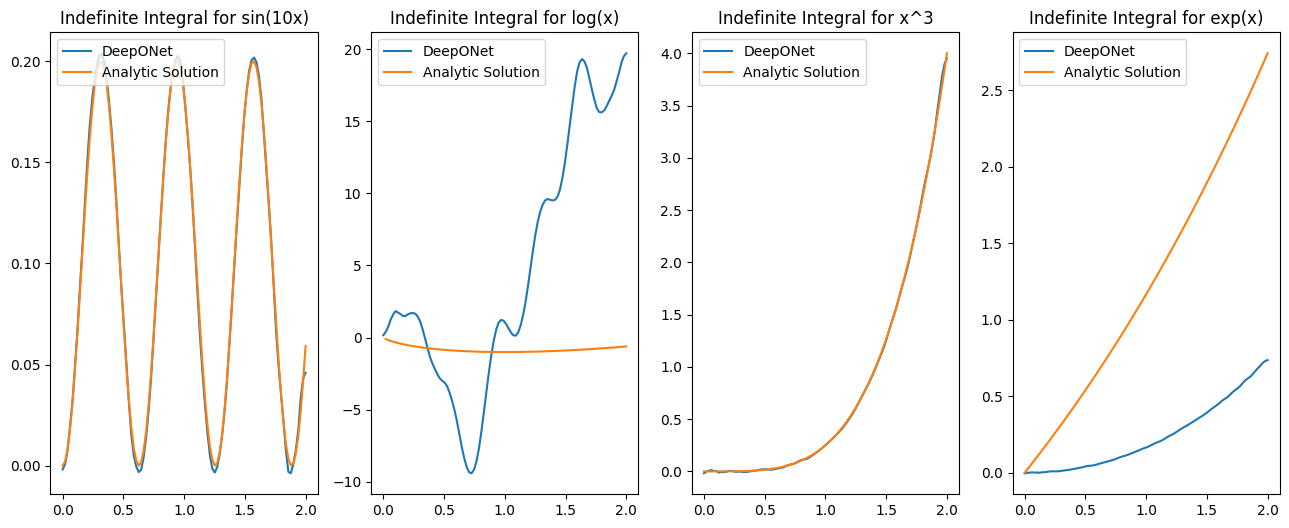

In [42]:
# Define test samples
# *Note: the initial condition requires y = 0
x1 = x2 = x3 = x4 = torch.linspace(0, 2, 100)

y1 = torch.sin(10 * x1)      ; out1 = -1/10 * (torch.cos(10 * x1) - 1)
y2 = torch.log(x2)           ; out2 = x2 * (torch.log(x2) - 1)
y3 = x3 ** 3                 ; out3 = 1/4 * x3 ** 4
y4 = torch.exp(0.3 * x4) - 1 ; out4 = 1/0.3 * (torch.exp(0.3 * x4) - 1)


x = [x1, x2, x3, x4]
y = [y1, y2, y3, y4]
out_true = [out1, out2, out3, out4]
titles = ["sin(10x)", "log(x)", "x^3", "exp(x)"]

test_onet(x, y, out_true, titles)

## Physics-informed DeepONet

We can also use physics informed training to train our Onet. In this example, we only use the derivative information and the initial condition $F(0)=0$ to train our network. No other data is used. For this example, we set the sampling point y to be the same as the points used to discretize $u(x)$ for convience.

This process takes longer and doesn't make too much sense for this example. But we can imagine problems where the sensors are sparse (e.g. only at the boundaries of domains) and therefore PINNs can be a good way to enforce laws at locations far from sensors.

To take derivatives efficiently, we use the `torch.func` library a jax like library designed for pytorch. We only want the derivatives of the output wrt to the sampling points y and not u(x). We use `vmap` to iterate over the 2 batch dimensions to achieve this and `jacrev` to calculate the derivatives.

Training takes quite a bit longer and is less stable but we require significantly less data/information about the Operator.

<img src='assets/img/PINO_vs_DataDriven.png'>

In [43]:
from torch.func import vmap, jacrev, grad

In [45]:
def batched_PINO_grad(net):
    def aux_net(net):
        def inner_func(*args, **kwargs):
            out = net(*args, **kwargs)
            return out, out
        return inner_func
    
    g = jacrev(aux_net(net), has_aux=True)
    # If y,u are the arg inputs, we only want to iterate over y's first dim (the query dim) not u

    grad_func = vmap(g, (0, None))

    return vmap(grad_func, 0)

In [46]:
PINO = DeepONet(75, 1, branch = MLP(100,75,75,4), trunk = MLP(1,75,75,4))

f = batched_PINO_grad(PINO)
y = torch.rand((5, 100, 1))
u = torch.rand((5, 1, 100))

grads, evals = f(y, u)
grads.shape, evals.shape, PINO(y, u).shape

(torch.Size([5, 100, 1, 1, 1]),
 torch.Size([5, 100, 1, 1]),
 torch.Size([5, 100, 1]))

In [47]:
ys, us, Guys = generate_data(10000, 0, 2, 100, 100, 5, 20)
Pino_data = Onet_dataset(ys, us, Guys)

# Onet_data.set_device('cuda')
Pino_DL = DataLoader(Pino_data, batch_size = 1000, shuffle = True)

optimiser = Adam(PINO.parameters())
lr_sch = torch.optim.lr_scheduler.StepLR(optimiser, 1000, 0.95)

In [48]:
evals[:,0].squeeze()

tensor([-3.3924e-05, -5.8363e-04, -1.1950e-04, -2.2813e-04, -1.8062e-05],
       grad_fn=<SqueezeBackward0>)

In [ ]:
PINO = PINO.cuda()
optimiser.zero_grad()

x = torch.linspace(0, 2, 100)
a = 4
dy = torch.sin(a*x)

dy_in = dy.unsqueeze(0).unsqueeze(1)
x_in = x.unsqueeze(0).unsqueeze(-1)
out_true = -1/a*(torch.cos(a*x)-1)
print(dy_in.shape,x_in.shape)

PINO_loss_list= []
PINO_acc_list = []

f = batched_PINO_grad(PINO)

for epoch in range(0, 7501):
    for (y, u, Guy) in Pino_DL:
        (y, u, Guy) = (y.cuda(), u.cuda(), Guy.cuda())

        grads,evals = f(y, u)

        #PINN loss
        PINN_loss = (grads.squeeze() - u.squeeze()).pow(2).mean()
        
        #Initial Condition Loss
        IC_loss = (evals[:,0].squeeze()).pow(2).mean()

        loss = 10 * PINN_loss + IC_loss
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        lr_sch.step()

    if (epoch % 100) == 0:
        print(f'{float(lr_sch.get_last_lr()[0]):.3E}')

        with torch.no_grad():
            out = PINO.cpu()(x_in, dy_in).squeeze()
            accuracy = (out - out_true).pow(2).mean()
            PINO = PINO.cuda()
        
        print(f'Epoch: {epoch} loss {float(loss):.3e} PINN Loss {float(PINN_loss):.3e} IC Loss {float(IC_loss):.3e} Acc {float(accuracy):.3e}')
        PINO_loss_list.append(float(loss))
        PINO_acc_list.append(float(accuracy))

In [ ]:
x = torch.linspace(0, 2, 100)
a = 12
dy = a * torch.sin(a * x)

dy_in = dy.unsqueeze(0).unsqueeze(1)
x_in = x.unsqueeze(0).unsqueeze(-1)
out_true = -1/a * (torch.cos(a * x) - 1)

with torch.no_grad():
    out = PINO.cpu()(x_in, dy_in).squeeze()
    out_dd = Onet.cpu()(x_in, dy_in).squeeze()

print(out.shape)

plt.plot(x, out, label = 'Physics Informed')
plt.plot(x, out_dd, label = 'Data Driven')
plt.plot(x, -(torch.cos(a * x) - 1), label = 'Analytic')
plt.legend()

In [ ]:
x = np.linspace(0, 7500, 76)

plt.plot(x, PINO_acc_list, label = 'Physics Informed')
plt.plot(x, acc_list, label = 'Data Driven')
plt.yscale('log')
plt.legend()
plt.title()

In [ ]:
x = np.linspace(0, 7500, 76)

plt.plot(x, PINO_loss_list, label = 'Physics Informed')
plt.plot(x, loss_list, label = 'Data Driven')
plt.yscale('log')
plt.legend()

In [ ]:
a, b = 0, 2

x = torch.linspace(a, b, 100)
c = 12
dy = c * torch.sin(c * x)

#Rescale
g = (dy - dy.min()) / (dy.max() - dy.min())

dy_in = dy.unsqueeze(0).unsqueeze(1)
g_in = g.unsqueeze(0).unsqueeze(1)
x_in = x.unsqueeze(0).unsqueeze(-1)

# out_true = -1/c * (torch.cos(c * x) - 1)

with torch.no_grad():
    G = PINO.cpu()(x_in, g_in).squeeze()
    out = PINO.cpu()(x_in, dy_in).squeeze()
    out_dd = Onet.cpu()(x_in, dy_in).squeeze()

    G_dd = Onet.cpu()(x_in, g_in).squeeze()

    dd_rescale = (dy.max() - dy.min()) * G_dd + dy.min() * x.squeeze()
    PINO_rescale = (dy.max() - dy.min()) * G + dy.min() * x.squeeze()

print(out.shape)

# out = torch.tensor(out).squeeze()
# plt.plot(x,out,label = 'Physics Informed')
# plt.plot(x,PINO_rescale,label = 'Physics Informed Rescaling')
plt.plot(x, out_dd, label = 'Data Driven')
plt.plot(x, dd_rescale, label = 'Data Driven Rescaling')
plt.plot(x, -(torch.cos(c * x) - 1), label = 'Analytic')
plt.legend()
plt.show()

plt.plot(x, G, label = 'Physics Informed')
plt.plot(x, g, label = 'Physics Informed')
# plt.plot(x,out_dd,label = 'Data Driven')
# plt.plot(x,,label = 'Analytic')
plt.legend()
plt.show()